# ADDA for ST

Creating something like CellDART but it actually follows Adda in PyTorch as a first step

In [1]:
import math
from math import ceil
import glob
import os
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ad

import scipy.stats as ss
from scipy.sparse import csr_matrix
import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch.nn import functional as F
from torch import nn

import datetime

# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
results_folder = os.path.join('results', script_start_time)
model_folder = os.path.join('model', script_start_time)

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)

if not os.path.isdir(results_folder):
    os.makedirs(results_folder)

model/2022-08-24_01h44m56


In [4]:
num_markers=20
n_mix = 8
n_spots = 20000

sample_id_n=151673

batch_size=512
num_workers=8
initial_train_epochs=100

early_stop_crit = 100
min_epochs = 100

# Define model components

In [5]:
class MLPEncoder(nn.Module):
    def __init__(self, inp_dim, emb_dim):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(inp_dim, 1024),
            nn.BatchNorm1d(1024, eps=0.001, momentum=0.99),
            nn.ELU(),

            nn.Linear(1024, emb_dim),
            nn.BatchNorm1d(emb_dim, eps=0.001, momentum=0.99),
            nn.ELU()
        )

    def forward(self, x):
        return self.encoder(x)

In [6]:
class Classifier(nn.Module):
    def __init__(self, emb_dim, ncls_source):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(emb_dim, ncls_source),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.head(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(emb_dim, 32),
            nn.BatchNorm1d(32, eps=0.001, momentum=0.99),
            nn.ELU(),
            nn.Dropout(0.5),

            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.head(x)

In [8]:
def set_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [9]:
class ADDAST(nn.Module):
    def __init__(self, inp_dim, emb_dim, ncls_source):
        super().__init__()

        self.source_encoder = MLPEncoder(inp_dim, emb_dim)
        self.target_encoder = MLPEncoder(inp_dim, emb_dim)
        self.clf = Classifier(emb_dim, ncls_source)
        self.dis = Discriminator(emb_dim)

        self.is_encoder_source = True

    def forward(self, x):
        if self.is_encoder_source:
            x = self.source_encoder(x)
        else:
            x = self.target_encoder(x)

        x = self.clf(x)

        return x

    def pretraining(self):
        self.is_encoder_source = True
        set_requires_grad(self.source_encoder, True)
        set_requires_grad(self.clf, True)

    def advtraining(self, train_dis=True):
        set_requires_grad(self.source_encoder, False)

        if train_dis:
            self.train_discriminator()
        else:
            self.train_target_encoder()

    def target_inference(self):
        self.is_encoder_source = False
        
    def train_discriminator(self):
        set_requires_grad(self.target_encoder, False)                
        set_requires_grad(self.dis, True)

    def train_target_encoder(self):
        set_requires_grad(self.target_encoder, True)                
        set_requires_grad(self.dis, False)

    def set_encoder(self, encoder="source"):
        if encoder=="source":
            self.is_encoder_source = True
        elif encoder=='target':
            self.is_encoder_source = False
        else:
            current_encoder_str = '\'source\'' if self.is_encoder_source else '\'target\''
            warnings.warn(
                f"encoder parameter should be 'source' or 'target', got {encoder}; encoder is currently {current_encoder_str}", 
                RuntimeWarning
            )


In [10]:
class SpotDataset(torch.utils.data.Dataset):
    """Dataset for cell spots. Returns a spot with GEx data, and optionally cell type distribution"""
    def __init__(self, X, Y=None):
        """
        Args:
            X (array_like of rank 2): An (n_spots, n_genes) array of normalized log gene expression values.
            Y (array_like of rank 2, optional): An (n_spots, n_cell_types) array of cell type distribution.
        """
        super().__init__()

        self.X = torch.as_tensor(X).float()
        assert self.X.dim() == 2, f"X should be rank 2, got {self.X.dim()}"

        if Y is None:
            self.Y = Y
        else:
            self.Y = torch.as_tensor(Y).float()
            assert self.Y.dim() == 2, f"Y should be rank 2, got {self.Y.dim()}"
            assert len(self.X) == len(self.Y), "X and Y unequal lengths"

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.Y is None:
            return self.X[idx]
        else:
            return self.X[idx], self.Y[idx]


# Prepare Data
## Data load
### Load SpatialLIBD Data

In [11]:
spatialLIBD_dir = './data/spatialLIBD'

sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

adata_dir = os.path.join(spatialLIBD_dir, 'adata')

adata_spatialLIBD_d = {}

for name in glob.glob(os.path.join(adata_dir, 'adata_spatialLIBD-*.h5ad')):
    sample_id = int(name.partition("-")[2].rpartition(".")[0])
    # print(sample_id)
    adata_spatialLIBD_d[sample_id] = sc.read_h5ad(name)

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
h5py                        3.6.0
igraph                      0.9.10
ipykernel                   6.9.1
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
joblib                      1.1.0
jupyter_server              1.18.1
kiwisolver                  1.4.2
leidenalg                   0.8.10
llvmlite                    0.38.0
matplotlib                  3.5.1
matplot

### Load Single Cell Data

In [12]:
adata_sc_dlpfc = sc.read_h5ad('./data/sc_dlpfc/adata_sc_dlpfc.h5ad')
adata_sc_dlpfc.var_names_make_unique()

## Find Marker Genes

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


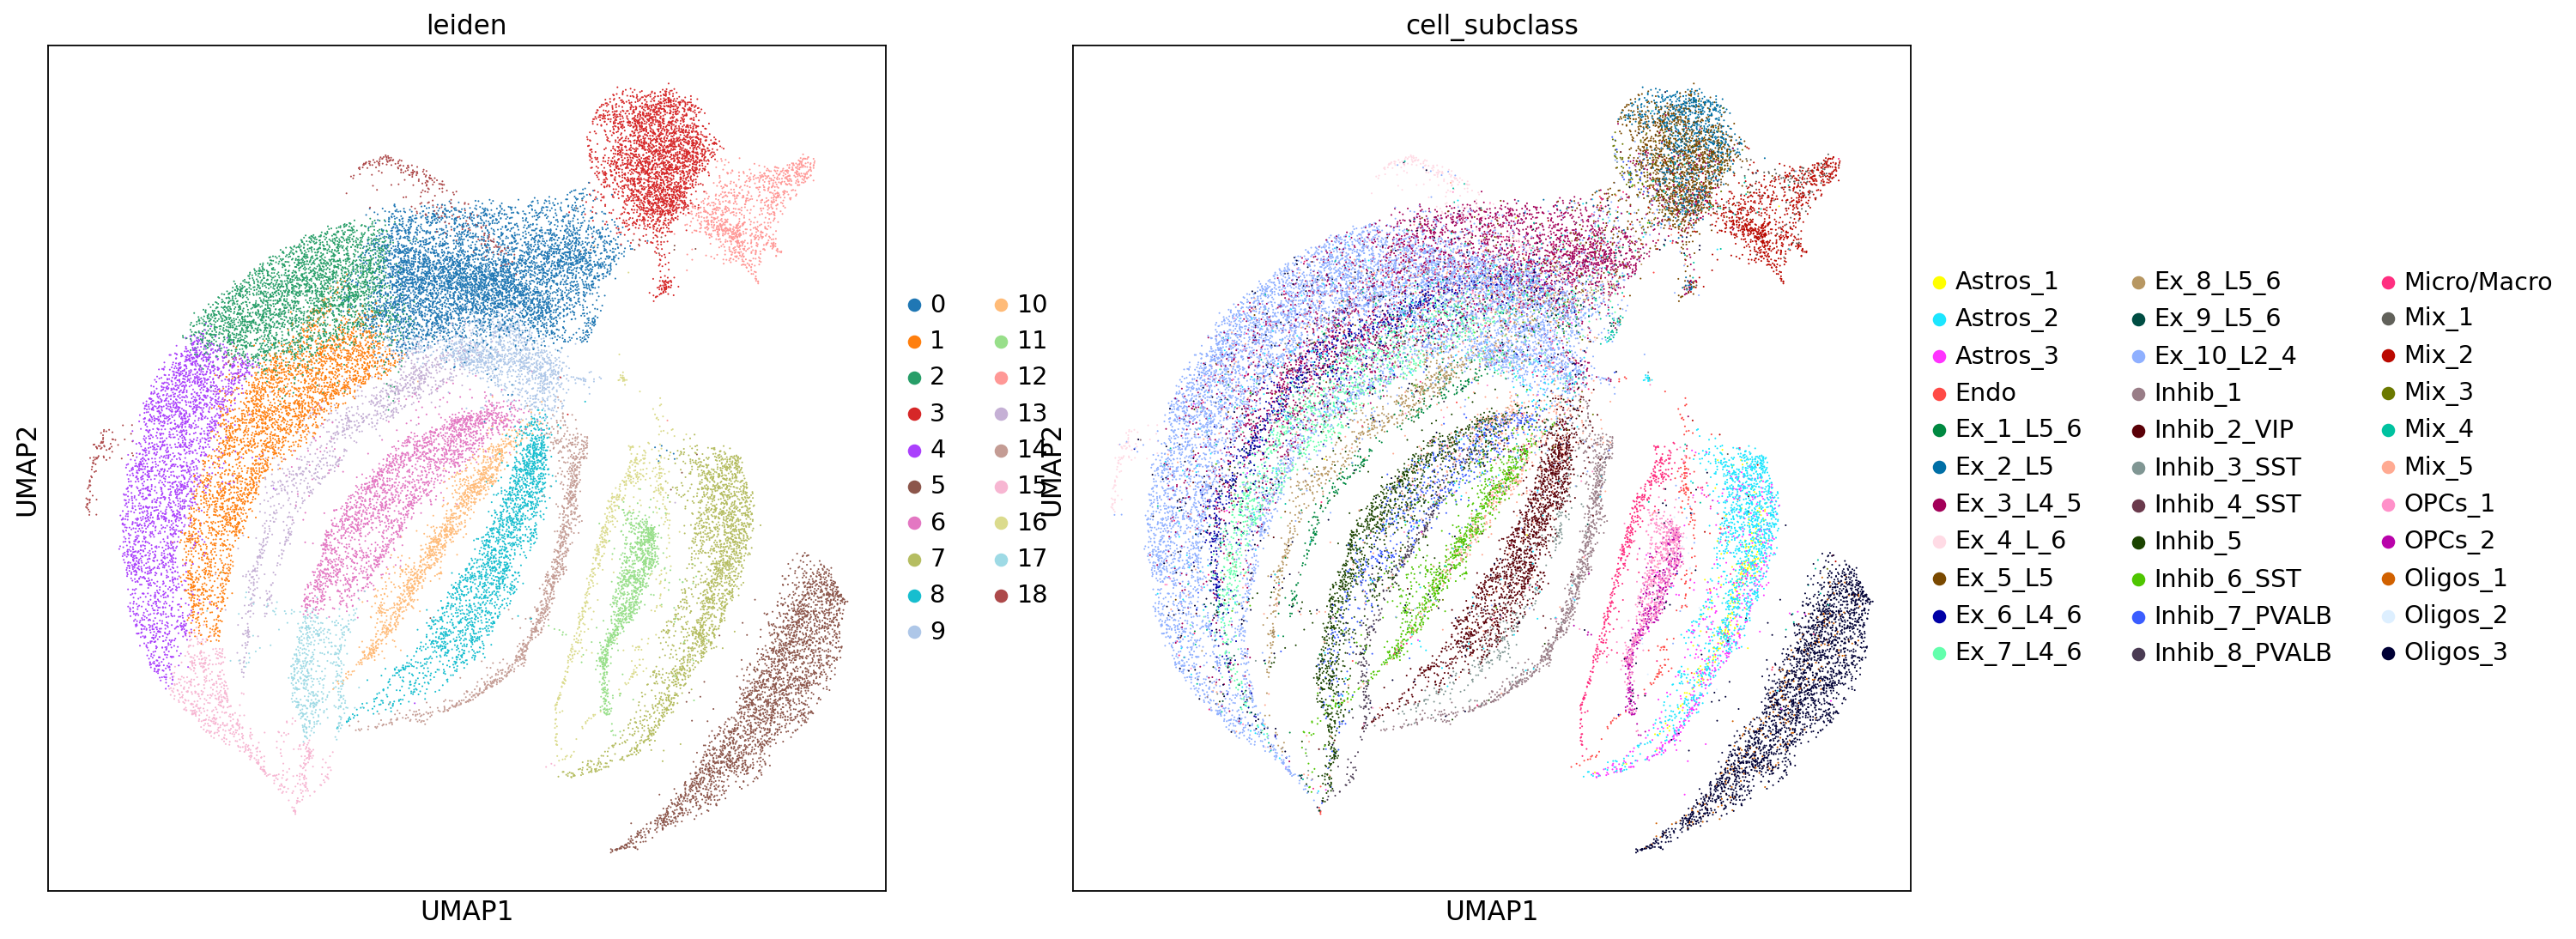

In [13]:
#Preprocessing
adata_sc_dlpfc.var['mt'] = adata_sc_dlpfc.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_sc_dlpfc, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pp.normalize_total(adata_sc_dlpfc)

#PCA and clustering : Known markers with 'cell_subclass'
sc.tl.pca(adata_sc_dlpfc, svd_solver='arpack')
sc.pp.neighbors(adata_sc_dlpfc, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_sc_dlpfc)
sc.tl.leiden(adata_sc_dlpfc, resolution = 0.5)
sc.pl.umap(adata_sc_dlpfc, color=['leiden','cell_subclass'])

In [14]:
sc.tl.rank_genes_groups(adata_sc_dlpfc, 'cell_subclass', method='wilcoxon')
sc.pl.rank_genes_groups(adata_sc_dlpfc, n_genes=20, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:58)


/home/wma/miniconda3/envs/agreda2/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/wma/miniconda3/envs/agreda2/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/wma/miniconda3/envs/agreda2/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:399: Performanc

In [15]:
genelists=adata_sc_dlpfc.uns['rank_genes_groups']['names']
df_genelists = pd.DataFrame.from_records(genelists)
df_genelists.head(5)

Astros_1 Astros_2 Astros_3   Endo Ex_1_L5_6 Ex_2_L5 Ex_3_L4_5 Ex_4_L_6  \
0      CLU   SLC1A2   SLC1A2  CLDN5     TSHZ2   MAP1B      CHN1   KCNIP4   
1   SLC1A3    PTGDS     GPC5    B2M     ASIC2  SNAP25      NRGN  ZNF804B   
2     APOE   SLC1A3   ADGRV1   FLT1     HTR2C   VSNL1   SLC17A7    RGS12   
3     GPC5     GPC5   SLC1A3  EPAS1   ZNF385D   CALM1    SNAP25   SORBS2   
4     GLUL   COL5A3    NPAS3   DLC1    HS3ST4   YWHAH      SNCB     ERC2   

  Ex_5_L5 Ex_6_L4_6  ...    Mix_1    Mix_2             Mix_3  Mix_4    Mix_5  \
0  SNAP25     TSHZ2  ...     FTH1     DHFR  TBC1D3P1-DHX40P1  PTGDS  CNTNAP2   
1    CHN1  IL1RAPL2  ...    CALM1      IDS             RPL32   NRGN   RBFOX1   
2   CALM1       DCC  ...      FTL     FTH1            ATP1B1  GRIN1    ROBO2   
3   MAP1B      RORB  ...    MAP1A    CALM1            SNAP25    MBP    GRIK1   
4    NRGN     PTPRD  ...  CAMK2N1  CAMK2N1             CALM1   MEG3   DLGAP1   

   OPCs_1  OPCs_2 Oligos_1  Oligos_2  Oligos_3  
0  LHFPL3  LHFPL3     PLP1     GPR17       MBP  
1  PCDH15  PTPRZ1   CTNNA3     BCAS1      PLP1  
2  LRRC4C  PCDH15     ST18   TMEM108     PCDH9  
3  PTPRZ1  LRRC4C      MBP  MIR219A2       QKI  
4   DSCAM   DSCAM      QKI     MAML2  IL1RAPL1  

[5 rows x 33 columns]

In [16]:
res_genes = []
for column in df_genelists.head(num_markers): 
    res_genes.extend(df_genelists.head(num_markers)[column].tolist())
res_genes_ = list(set(res_genes))

### Select same gene features 

In [17]:
adata_spatialLIBD = ad.concat(adata_spatialLIBD_d.values(), label='sample_id', keys = adata_spatialLIBD_d.keys())
adata_spatialLIBD.obs_names_make_unique()

/home/wma/miniconda3/envs/agreda2/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [18]:
adata_spatialLIBD.var_names_make_unique() 
inter_genes = [val for val in res_genes_ if val in adata_spatialLIBD.var.index]
print('Selected Feature Gene number',len(inter_genes))
adata_sc_dlpfc = adata_sc_dlpfc[:,inter_genes]

adata_spatialLIBD = adata_spatialLIBD[:,inter_genes]

Selected Feature Gene number 362


## Format Data

In [19]:
mat_sc = adata_sc_dlpfc.X.todense()
mat_sp_train = adata_spatialLIBD[adata_spatialLIBD.obs.sample_id == sample_id_n].X.todense()
# mat_sp_train = adata_spatialLIBD.X.todense()
mat_sp_test = adata_spatialLIBD[adata_spatialLIBD.obs.sample_id == sample_id_n].X.todense()

df_sc = adata_sc_dlpfc.obs

lab_sc_sub = df_sc.cell_subclass
sc_sub_dict = dict(zip(range(len(set(lab_sc_sub))), df_genelists.columns.tolist()))
sc_sub_dict2 = dict((y,x) for x,y in sc_sub_dict.items())
lab_sc_num = [sc_sub_dict2[ii] for ii in lab_sc_sub]
lab_sc_num = np.asarray(lab_sc_num, dtype='int')

## Generate Pseudospots

In [20]:
from sklearn.preprocessing import OneHotEncoder

def random_mix(Xs, ys, nmix=5, n_samples=10000, seed=0):
    # Define empty lists
    Xs_new, ys_new =[], []
    ys_ = OneHotEncoder().fit_transform(ys.reshape(-1, 1)).toarray()

    rstate = np.random.RandomState(seed)
    fraction_all = rstate.rand(n_samples, nmix)
    randindex_all = rstate.randint(len(Xs), size=(n_samples,nmix))

    for i in range(n_samples):
        # fraction: random fraction across the "nmix" number of sampled cells
        fraction = fraction_all[i]
        fraction = fraction/np.sum(fraction)
        fraction = np.reshape(fraction, (nmix,1))
        
        # Random selection of the single cell data by the index
        randindex = randindex_all[i]
        ymix = ys_[randindex]
        # Calculate the fraction of cell types in the cell mixture
        yy = np.sum(ymix*fraction, axis=0)
        # Calculate weighted gene expression of the cell mixture
        XX = np.asarray(Xs[randindex])*fraction
        XX_ = np.sum(XX, axis=0)
        
        # Add cell type fraction & composite gene expression in the list
        ys_new.append(yy)
        Xs_new.append(XX_)

    Xs_new = np.asarray(Xs_new)
    ys_new = np.asarray(ys_new)

    return Xs_new, ys_new

In [21]:
mat_sc_train, mat_sc_test, lab_sc_num_train, lab_sc_num_test = train_test_split(
    mat_sc, lab_sc_num, test_size=0.2, random_state=225,stratify = lab_sc_num
)


sc_mix_train, lab_mix_train = random_mix(mat_sc_train, lab_sc_num_train, nmix=n_mix, n_samples=n_spots)
sc_mix_test, lab_mix_test = random_mix(mat_sc_test, lab_sc_num_test, nmix=n_mix, n_samples=n_spots // 4)

def log_minmaxscale(arr):
    arrd = len(arr)
    arr = np.log1p(arr)
    return (arr-np.reshape(np.min(arr,axis=1), (arrd,1)))/np.reshape((np.max(arr, axis=1)-np.min(arr,axis=1)),(arrd,1))

sc_mix_train_s = log_minmaxscale(sc_mix_train)
sc_mix_test_s = log_minmaxscale(sc_mix_test)

mat_sp_train_s = log_minmaxscale(mat_sp_train)
mat_sp_test_s = log_minmaxscale(mat_sp_test)
mat_sc_s = log_minmaxscale(mat_sc)

In [22]:
source_train_set = SpotDataset(sc_mix_train_s, lab_mix_train)
source_test_set = SpotDataset(sc_mix_test_s, lab_mix_test)

target_train_set = SpotDataset(mat_sp_train_s)
target_test_set = SpotDataset(mat_sp_test_s)

dataloader_source_train = torch.utils.data.DataLoader(source_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
dataloader_source_test = torch.utils.data.DataLoader(source_test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

dataloader_target_train = torch.utils.data.DataLoader(target_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
dataloader_target_test = torch.utils.data.DataLoader(target_test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# Training: Adversarial domain adaptation for cell fraction estimation

In [23]:
model = ADDAST(
    sc_mix_train_s.shape[1],
    emb_dim=64,
    ncls_source=lab_mix_train.shape[1]
)

model.to(device)

CellDART_ADDA(
  (source_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (target_encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=362, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=1024, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
  )
  (clf): Classifier(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=33, bias=True)
      

## Pretrain

In [24]:
pretrain_folder = os.path.join(model_folder, "pretrain")

if not os.path.isdir(pretrain_folder):
    os.makedirs(pretrain_folder)

In [25]:
pre_optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    eps = 1e-07
)

criterion = nn.KLDivLoss(reduction="batchmean")

In [26]:
def compute_acc(dataloader, model):
    loss_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, (x, y_true) in enumerate(dataloader):

            x = x.to(torch.float32).to(device)
            y_true = y_true.to(torch.float32).to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y_true)

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(x))

    # print(len(loss_running), len(mean_weights))
    return np.average(loss_running, weights=mean_weights)

In [27]:
model.pretraining()

In [28]:
from tqdm.autonotebook import tqdm

# Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []


loss_history_running = []
# accu_history_running = []
# lr_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0


# Train
print("Start pretrain...")
outer = tqdm(total=initial_train_epochs, desc='Epochs', position=0)
inner = tqdm(total=len(dataloader_source_train), desc=f'Batch', position=1)
for epoch in range(initial_train_epochs):

    # check to see if validation loss has plateau'd
    if early_stop_count >= early_stop_crit and epoch > min_epochs:
        print(f'Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch')
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': pre_optimizer,
            # 'scheduler': scheduler,
            # 'scaler': scaler
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f'checkpt_earlystop_{epoch}.pth'))
        break
    
    early_stop_count += 1
    
    #Train mode
    model.train()
    loss_running = []
    # accu_running = []
    mean_weights = []
    
    inner.refresh()  #force print final state
    inner.reset()  #reuse bar    
    for _, (x, y_true) in enumerate(dataloader_source_train):
        # lr_history_running.append(scheduler.get_last_lr())
        
        
        pre_optimizer.zero_grad()
        x = x.to(torch.float32).to(device)
        y_true = y_true.to(torch.float32).to(device)

        y_pred = model(x)

        loss = criterion(y_pred, y_true)

        loss_running.append(loss.item())


        # we will weight average by batch size later
        mean_weights.append(len(x))

        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        loss.backward()
        pre_optimizer.step()
        # Change the learning rate
        # scheduler.step()
        
        inner.update(1)
        
    loss_history.append(np.average(loss_running, weights=mean_weights))
    # accu_history.append(np.average(accu_running, weights=mean_weights))
    
    loss_history_running.append(loss_running)
    # accu_history_running.append(loss_running)



    # Evaluate mode
    model.eval()
    with torch.no_grad():    
        curr_loss_val = compute_acc(dataloader_source_train, model)
        loss_history_val.append(curr_loss_val)
    


    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': pre_optimizer,
            # 'scheduler': scheduler,
            # 'scaler': scaler
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f'best_model.pth'))
        early_stop_count = 0
    
    
    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= initial_train_epochs-1:
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': pre_optimizer,
            # 'scheduler': scheduler,
            # 'scaler': scaler
        }
        torch.save(checkpoint, os.path.join(pretrain_folder, f'checkpt{epoch}.pth'))
        
    # Print the results    
    outer.update(1)
    print(
        "epoch:", epoch, \
        "train loss:", round(loss_history[-1], 6), \
        "validation loss:", round(loss_history_val[-1], 6), \
        # "validation accuracy:", round(accu_history_val[-1], 6), \
        # "next_lr:", scheduler.get_last_lr(),
    )


# Save final model 
checkpoint = { 
    'epoch': epoch,
    'model': model,
    'optimizer': pre_optimizer,
    # 'scheduler': scheduler,
    # 'scaler': scaler
}
torch.save(checkpoint, os.path.join(pretrain_folder, f'final_model.pth'))

Start pretrain...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch: 0 train loss: 1.234698 validation loss: 1.067884
epoch: 1 train loss: 0.890165 validation loss: 0.784547
epoch: 2 train loss: 0.721132 validation loss: 0.65355
epoch: 3 train loss: 0.634285 validation loss: 0.611119
epoch: 4 train loss: 0.59627 validation loss: 0.585229
epoch: 5 train loss: 0.572403 validation loss: 0.553484
epoch: 6 train loss: 0.555137 validation loss: 0.563411
epoch: 7 train loss: 0.537583 validation loss: 0.556849
epoch: 8 train loss: 0.523272 validation loss: 0.521586
epoch: 9 train loss: 0.510215 validation loss: 0.517191
epoch: 10 train loss: 0.496524 validation loss: 0.504643
epoch: 11 train loss: 0.48293 validation loss: 0.51118
epoch: 12 train loss: 0.472089 validation loss: 0.474176
epoch: 13 train loss: 0.462926 validation loss: 0.510136
epoch: 14 train loss: 0.446258 validation loss: 0.469493
epoch: 15 train loss: 0.43631 validation loss: 0.515905
epoch: 16 train loss: 0.423667 validation loss: 0.447318
epoch: 17 train loss: 0.411859 validation loss

In [29]:
x.shape

torch.Size([32, 362])

In [30]:
# torch.exp(F.log_softmax(y_pred,dim=1)[0]).sum()